# 1. Make necessary imports

In [1]:
import random
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time  # для оценки времени

import gc

import html
from collections import defaultdict
import matplotlib.pyplot as plt

# 2. Define variables, classes and functions necessary for making datasets

## 2.1 Create two versions of alphabet string: one containing letters only and an extended one with punctuation marks

__We'll use the letter-only alphabet in our Caesar cipher encoding function, while the extended alphabet will be used to convert _all_ the symbols to integers__

In [2]:
azb = ''.join([chr(i) for i in range(ord('А'),ord('А')+38)] +
              [chr(ord('А')+65)] +
              [chr(i) for i in range(ord('А')+38,ord('А')+64)])
print(azb)
azb_extra = " .,;:!?\'\"«»–-—()"
print(azb + azb_extra)

АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя
АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя .,;:!?'"«»–-—()


## 2.2 Based on either alphabet, create two dictionaries

In [3]:
# uppercase_letters = string.ascii_uppercase
vocab = {letter:i for i,letter in enumerate(azb)}
vocab_plus = {letter:i for i,letter in enumerate(azb + azb_extra)}

In [4]:
print(vocab, len(vocab))

{'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ж': 6, 'З': 7, 'И': 8, 'Й': 9, 'К': 10, 'Л': 11, 'М': 12, 'Н': 13, 'О': 14, 'П': 15, 'Р': 16, 'С': 17, 'Т': 18, 'У': 19, 'Ф': 20, 'Х': 21, 'Ц': 22, 'Ч': 23, 'Ш': 24, 'Щ': 25, 'Ъ': 26, 'Ы': 27, 'Ь': 28, 'Э': 29, 'Ю': 30, 'Я': 31, 'а': 32, 'б': 33, 'в': 34, 'г': 35, 'д': 36, 'е': 37, 'ё': 38, 'ж': 39, 'з': 40, 'и': 41, 'й': 42, 'к': 43, 'л': 44, 'м': 45, 'н': 46, 'о': 47, 'п': 48, 'р': 49, 'с': 50, 'т': 51, 'у': 52, 'ф': 53, 'х': 54, 'ц': 55, 'ч': 56, 'ш': 57, 'щ': 58, 'ъ': 59, 'ы': 60, 'ь': 61, 'э': 62, 'ю': 63, 'я': 64} 65


In [5]:
print(vocab_plus, len(vocab_plus))

{'А': 0, 'Б': 1, 'В': 2, 'Г': 3, 'Д': 4, 'Е': 5, 'Ж': 6, 'З': 7, 'И': 8, 'Й': 9, 'К': 10, 'Л': 11, 'М': 12, 'Н': 13, 'О': 14, 'П': 15, 'Р': 16, 'С': 17, 'Т': 18, 'У': 19, 'Ф': 20, 'Х': 21, 'Ц': 22, 'Ч': 23, 'Ш': 24, 'Щ': 25, 'Ъ': 26, 'Ы': 27, 'Ь': 28, 'Э': 29, 'Ю': 30, 'Я': 31, 'а': 32, 'б': 33, 'в': 34, 'г': 35, 'д': 36, 'е': 37, 'ё': 38, 'ж': 39, 'з': 40, 'и': 41, 'й': 42, 'к': 43, 'л': 44, 'м': 45, 'н': 46, 'о': 47, 'п': 48, 'р': 49, 'с': 50, 'т': 51, 'у': 52, 'ф': 53, 'х': 54, 'ц': 55, 'ч': 56, 'ш': 57, 'щ': 58, 'ъ': 59, 'ы': 60, 'ь': 61, 'э': 62, 'ю': 63, 'я': 64, ' ': 65, '.': 66, ',': 67, ';': 68, ':': 69, '!': 70, '?': 71, "'": 72, '"': 73, '«': 74, '»': 75, '–': 76, '-': 77, '—': 78, '(': 79, ')': 80} 81


## 2.3 Define Caesar cipher encrypting function as per [Caesar cipher definition](https://en.wikipedia.org/wiki/Caesar_cipher)

__Our function will use the shorter dictionary of the two, because it will only encrypt letters and leave all the other symbols unchanged__

In [6]:
def caesar(s_in, vocab, shift=1):
    if type(s_in) == list:
        return [caesar(s,vocab,shift) for s in s_in]
    s_out = ''
    for ch in s_in:
        if ch not in vocab.keys():
            s_out += ch
        else:
            ind = vocab[ch]
            mark = vocab['а']
            if ind < mark:
                new_ind = (ind + shift) % mark
            else:
                new_ind = mark + (ind + shift - mark) % (len(vocab) - mark)
            s_out += list(vocab.keys())[new_ind]
    return s_out

## 2.4 Define Dataset class

__Based on a given list of strings (labeled as sequences parameter here), our Dataset object will create a list of encrypted versions of those strings along with the original strings labeled as targets. Encrypting function passed as a parameter for object initialization method uses a letter-only dictionary (labeled as vocab_encrypt parameter here). Our class also has a method for outputting a tuple of string + target according to the index passed as parameter - both converted to tensor of integers.__

__Notice also how our Dataset class encodes characters as single integers, rather than one-hot vectors.__

__Method performing string to integer conversion uses an extended dictionary (labeled as vocab_long parameter here) in order to individually encode every possible symbol. For an unknown symbol it outputs len(vocab_long), rather than -1, which is harder to handle further down the line, in the emdebbing layer. Anyway, we'll process our data so that no unknwon symbols creep in, because they can affect our network learning.__

In [7]:
class CaesarDataset(Dataset):
    def __init__(self, sequences, vocab_long, encrypt = caesar, vocab_encrypt = None, shift = 1):
        self.vocab_long = vocab_long
        if vocab_encrypt == None:
            self.vocab_encrypt = vocab_long
        else:
            self.vocab_encrypt = vocab_encrypt
        self.targets = sequences
        self.shift = shift
        self.data = encrypt(self.targets, self.vocab_encrypt, shift)        
#         self.strlen = strlen
    def __len__(self):
        return len(self.data)
    def str2ints(self, seq):
        if type(seq) == list:
            return [self.str2ints(s) for s in seq]
        return [self.vocab_long.get(ch, len(self.vocab_long)) for ch in seq] ##USE VOCAB LENGTH, NOT -1, FOR UNKNOWN
    def __getitem__(self, idx):
        input_seqs = self.data[idx]
        target_seqs = self.targets[idx]
        return torch.tensor(self.str2ints(input_seqs),dtype=torch.long), torch.tensor(self.str2ints(target_seqs),
                                                                                      dtype=torch.long)
#         return self.str2ints(input_seqs), self.str2ints(target_seqs)

# 3. Make dataset using natural language texts

## 3.1 Get a collection of Russian proverbs from a [Wikipedia page](https://ru.wikiquote.org/wiki/Русские_пословицы)

__By looking at the html-layout of the page, we can see that the div section that contains the (unordered) list of proverbs has id="mw-content-text". Further inspection shows that the list elements we need don't have class attribute. We're now ready to loop through the list, extracting text content of list items and storing it as strings in a list. Before adding proverb to our list, we clean out some fancy code points, and check if the proverb only contains symbols of our extended alphabet.__

__We also find the max and min string length in our proverb list.__

In [8]:
from bs4 import BeautifulSoup
import requests
html_content = requests.get(url = 'https://ru.wikiquote.org/wiki/Русские_пословицы').content
data = BeautifulSoup(html_content, 'html.parser')
  
#finding the div with the id 
divtag = data.find('div', id = "mw-content-text")
proverbs = []
ultags = divtag.find_all("ul")
# print(len(ultags))
for ultag in ultags:
    litags = ultag.find_all("li", class_=None)
    for litag in litags:
        proverb = litag.text.replace("\xa0", " ") # REPLACE NON-BREAKING SPACE WITH ORDINARY WWHITESPACE
        proverb = u"".join([c for c in proverb if ord(c) != 769]) #REMOVE STRESS MARKS IF ENCODED SEPARATELY
        for ch in proverb:                     #USE FOR-ELSE IDIOM TO LEAVE OUT STRINGS WITH UNKNOWN SYMBOLS
            if ch not in azb + azb_extra:
                break
        else:
            proverbs.append(proverb)
            
length = len(proverbs)
print("Number of proverbs:", length)
max_len, min_len = -1, len(proverbs[0])
for proverb in proverbs:
    if len(proverb) > max_len:
        max_len = len(proverb)
    if len(proverb) < min_len:
        min_len = len(proverb)
print("Max string length is {}, min string length is {}.".format(max_len, min_len))
print("First 10 proverbs:")
print(proverbs[:10])

Number of proverbs: 3659
Max string length is 122, min string length is 11.
First 10 proverbs:
['А где щи, тут и нас ищи.', 'А ещё говорят, в Москве кур доят (а пошли и титек не нашли).', 'А как худ князь, так и в грязь.', 'А когда досуг-то будет? — А когда нас не будет.', 'А кто слыхал, чтоб медведь летал?', 'А не пьян, так хмелён.', 'А уже Вавилу запрятали в могилу.', 'Абросим не просит, а дадут — не бросит.', 'Август-батюшка заботой-работой мужика тешит.', 'Авирон не боится  ворон, а на галки есть палки.']


## 3.2 Create a proverb dataset and split it into train and test subsets

__We'll use a 30% split, which is an arbitrary choice and we won't optimize it here. Our Caesar cipher will use a shift of 2 characters.__

In [9]:
ds_prov = CaesarDataset(proverbs, vocab_plus, caesar, vocab, 2)
train_data, test_data = torch.utils.data.random_split(ds_prov, ( int((length*0.3)), length-int((length*0.3)) ) )

## 3.3 Define collate functions for packing string batches, in order to be able to handle variable length strings

__We could use a function that either only packs or both pads _and then_ packs sequences. In our dataloader we'll used the pad+pack one.__

In [10]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_packed = torch.nn.utils.rnn.pack_sequence(X, enforce_sorted=False)

#     return X_pack, torch.as_tensor(y).view(-1, 1)
    return X_packed, y

In [11]:
def pad_and_pack_collate(batch):
    input_tensors = []
    labels = []
    lengths = []
    for X, y in batch:
        input_tensors.append(X)
        labels.append(y)
        lengths.append(X.shape[0]) #Assume shape is (T, *)
    X_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=False)
    X_packed = torch.nn.utils.rnn.pack_padded_sequence(X_padded, lengths, batch_first=False, enforce_sorted=False)
    return X_packed, labels

## 3.4 Create a dummy batch to make some checks

__It will be a batch of the type that our dataloader would extract using the get_item method of the dataset class.__

In [12]:
dummy_batch = [train_data[0], train_data[1]]
print(dummy_batch)

[(tensor([19, 62, 51, 49, 37, 49, 65, 48, 39, 65, 39, 47, 67, 65, 41, 34, 51, 39,
        48, 49, 37, 49, 65, 48, 39, 65, 56, 49, 58, 54, 67, 65, 36, 34, 51, 40,
        48, 49, 37, 49, 65, 53, 39, 51, 50, 39, 53, 63, 65, 48, 39, 65, 47, 49,
        37, 54, 66]), tensor([17, 60, 49, 47, 35, 47, 65, 46, 37, 65, 37, 45, 67, 65, 39, 32, 49, 37,
        46, 47, 35, 47, 65, 46, 37, 65, 54, 47, 56, 52, 67, 65, 34, 32, 49, 38,
        46, 47, 35, 47, 65, 51, 37, 49, 48, 37, 51, 61, 65, 46, 37, 65, 45, 47,
        35, 52, 66])), (tensor([14, 48, 49, 37, 49, 65, 42, 48, 34, 53, 63, 65, 78, 65, 47, 34, 46, 49,
        65, 52, 50, 34, 53, 63, 66]), tensor([12, 46, 47, 35, 47, 65, 40, 46, 32, 51, 61, 65, 78, 65, 45, 32, 44, 47,
        65, 50, 48, 32, 51, 61, 66]))]


In [13]:
print(pad_and_pack_collate(dummy_batch))

(PackedSequence(data=tensor([19, 14, 62, 48, 51, 49, 49, 37, 37, 49, 49, 65, 65, 42, 48, 48, 39, 34,
        65, 53, 39, 63, 47, 65, 67, 78, 65, 65, 41, 47, 34, 34, 51, 46, 39, 49,
        48, 65, 49, 52, 37, 50, 49, 34, 65, 53, 48, 63, 39, 66, 65, 56, 49, 58,
        54, 67, 65, 36, 34, 51, 40, 48, 49, 37, 49, 65, 53, 39, 51, 50, 39, 53,
        63, 65, 48, 39, 65, 47, 49, 37, 54, 66]), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1])), [tensor([17, 60, 49, 47, 35, 47, 65, 46, 37, 65, 37, 45, 67, 65, 39, 32, 49, 37,
        46, 47, 35, 47, 65, 46, 37, 65, 54, 47, 56, 52, 67, 65, 34, 32, 49, 38,
        46, 47, 35, 47, 65, 51, 37, 49, 48, 37, 51, 61, 65, 46, 37, 65, 45, 47,
        35, 52, 66]), tensor([12, 46, 47, 35, 47, 65, 40, 46, 32, 51, 61, 65, 78, 65, 45, 32, 

In [14]:
print(pack_collate(dummy_batch))

(PackedSequence(data=tensor([19, 14, 62, 48, 51, 49, 49, 37, 37, 49, 49, 65, 65, 42, 48, 48, 39, 34,
        65, 53, 39, 63, 47, 65, 67, 78, 65, 65, 41, 47, 34, 34, 51, 46, 39, 49,
        48, 65, 49, 52, 37, 50, 49, 34, 65, 53, 48, 63, 39, 66, 65, 56, 49, 58,
        54, 67, 65, 36, 34, 51, 40, 48, 49, 37, 49, 65, 53, 39, 51, 50, 39, 53,
        63, 65, 48, 39, 65, 47, 49, 37, 54, 66]), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1])), [tensor([17, 60, 49, 47, 35, 47, 65, 46, 37, 65, 37, 45, 67, 65, 39, 32, 49, 37,
        46, 47, 35, 47, 65, 46, 37, 65, 54, 47, 56, 52, 67, 65, 34, 32, 49, 38,
        46, 47, 35, 47, 65, 51, 37, 49, 48, 37, 51, 61, 65, 46, 37, 65, 45, 47,
        35, 52, 66]), tensor([12, 46, 47, 35, 47, 65, 40, 46, 32, 51, 61, 65, 78, 65, 45, 32, 

__There is no single operator or function to compare two packed sequences, but visual inspection shows that both functions produce the same output.__

## 3.5 Define data loaders

In [15]:
BATCH_SIZE = 10

In [16]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_and_pack_collate)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_pack_collate)

# 4. Build RNN-based model

__We're going to used a simple RNN-based model consisting of an embedding layer, an RNN layer and a fully-connected linear classifier layer. But we'll make some important additions to that.__

## 4.1 Define a wrapper for the embedding layer

__The embedding layer in PyTorch does not support Packed Sequence objects. This wrapper class will fix that. It'll do the following, if the input is a packed batch:__ 
- __unpack and pad (if not already padded),__
- __embed__
- __re-pack again.__

In [17]:
class EmbedPacked(nn.Module):
    def __init__(self, embd_layer):
        super(EmbedPacked, self).__init__()
        self.embd_layer = embd_layer 
    
    def forward(self, input):
        if type(input) == torch.nn.utils.rnn.PackedSequence:
            # We need to unpack the input, 
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            #Embed it
            sequences = self.embd_layer(sequences.to(input.data.device))
            #And pack it into a new sequence
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), 
                                                           batch_first=True, enforce_sorted=False)
        else:#apply to normal data
            return self.embd_layer(input)


## 4.2 Define an intermediate module between RNN layer and linear classifier layer

__We're going to need another module between our RNN layer and linear classifier layer. This additional module will do the following:__
1. __By convention RNN outputs a tuple of two tensors: one that contains all hidden states + one that only contains the last hidden state (sometimes the second object is another tuple, containing the last hidden state). Since we'll do many-to-many classification, our intermediate module will extract the first tensor with _all_ the hidden states that the RNN creates as it processes each token.__
2. __The module will concatenate all the tensors in the batch into a single long one. It will take the form of a tensor consisting of hidden state vectors that the linear classifier will then tansform into a vector of integers. It is this vector of integers that will be fed to our loss function, along with target integers, also squeezed into a single vector. In short, after unpacking, our module transforms a _(batch number, max seq length, hidden vector length)_ tensor into a _(sum of seq lengths, hidden v length)_ tensor.__
3. __Since our embedding wrapper produces a zero-padded batch after unpacking, we need to get rid of those zeros. Our additional module does that using the original lengths of the sequences, that are part of the output that the unpacking function produces.__ 

__Actually, we could have done batch concatenation outside this module, or outside the RNN model object even, during training itself, but here we chose to tuck this step inside the model. On the other hand, we excluded calculating loss from our model class.__

In [18]:
class afterRNN(nn.Module):
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(afterRNN, self).__init__()    
    def forward(self, input):
        out_unpacked, seq_sizes = torch.nn.utils.rnn.pad_packed_sequence(input[0], batch_first=True)
        batches_combined = torch.cat([out_unpacked[i][:seq_sizes[i]] for i in range(len(seq_sizes))])
        return batches_combined

## 4.3 Build final model

In [19]:
D = 20

In [20]:
hidden_nodes = 10

In [21]:
simple_rnn = nn.Sequential(
  EmbedPacked(nn.Embedding(len(vocab_plus), D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here
  afterRNN(),
  nn.Linear(hidden_nodes, len(vocab_plus)), #(B, D) -> (B, classes)
)

## 4.4 Check shapes of intermediate objects

__Alternatively, our model can be defined as object of a class inherting directly from torch.nn.Module class, using our EmbedPacked module class defined earlier, i.e. outside the model class itself. We could use AfteRNN module as well here, but instead the corresponding steps are simply included in the forward function. This allows us to check the shape of intermediate objects:__

In [22]:
class simple_rnn_model (torch.nn.Module):
    def __init__(self, D, hidden_nodes, len_vocab):
        super().__init__()
        self.embedpacked = EmbedPacked(torch.nn.Embedding(len_vocab, D))
        self.rnn = torch.nn.RNN(D, hidden_nodes, batch_first=True)
        self.linear = torch.nn.Linear(hidden_nodes, len_vocab)
        
    def forward(self, batch, state=None):
        print("Batch is of type", type(batch))
        
        embedded = self.embedpacked(batch)
        out, h = self.rnn(embedded)
        out_unpacked, seq_sizes = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        print("Shape after unpacking is", out_unpacked.shape)
        batches_combined = torch.cat([out_unpacked[i][:seq_sizes[i]] for i in range(len(seq_sizes))])
#         batches_combined = AfterRNN()((out, h))
        print("Shape after concatenating batches is", batches_combined.shape)
        return self.linear(batches_combined)
        
#         print(type(o), type(h), h.shape)
#         return self.linear(o.data)

In [23]:
simple_rnn_model_print_shapes = simple_rnn_model(D, hidden_nodes, len(vocab_plus))

__Our dummy batch consists of a 31-character long proverb (encrypted and decrypted) and a 27-character long one:__

In [24]:
print(dummy_batch[0][0].shape, dummy_batch[0][1].shape,dummy_batch[1][0].shape,dummy_batch[1][1].shape)

torch.Size([57]) torch.Size([57]) torch.Size([25]) torch.Size([25])


In [25]:
ppb = pad_and_pack_collate(dummy_batch)
ppb

(PackedSequence(data=tensor([19, 14, 62, 48, 51, 49, 49, 37, 37, 49, 49, 65, 65, 42, 48, 48, 39, 34,
         65, 53, 39, 63, 47, 65, 67, 78, 65, 65, 41, 47, 34, 34, 51, 46, 39, 49,
         48, 65, 49, 52, 37, 50, 49, 34, 65, 53, 48, 63, 39, 66, 65, 56, 49, 58,
         54, 67, 65, 36, 34, 51, 40, 48, 49, 37, 49, 65, 53, 39, 51, 50, 39, 53,
         63, 65, 48, 39, 65, 47, 49, 37, 54, 66]), batch_sizes=tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1])),
 [tensor([17, 60, 49, 47, 35, 47, 65, 46, 37, 65, 37, 45, 67, 65, 39, 32, 49, 37,
          46, 47, 35, 47, 65, 46, 37, 65, 54, 47, 56, 52, 67, 65, 34, 32, 49, 38,
          46, 47, 35, 47, 65, 51, 37, 49, 48, 37, 51, 61, 65, 46, 37, 65, 45, 47,
          35, 52, 66]),
  tensor([12, 46, 47, 35, 47, 65, 40, 46, 32, 51, 61, 65, 7

In [26]:
with torch.no_grad():
#     print(simple_rnn(ppb[0].to(device)), simple_rnn(ppb[0].to(device)).shape)
    res_prints = simple_rnn_model_print_shapes.forward(ppb[0])
    print("Shape returned by model is", res_prints.shape)
#     print(simple_rnn(ppb[0].to(device)))

Batch is of type <class 'torch.nn.utils.rnn.PackedSequence'>
Shape after unpacking is torch.Size([2, 57, 10])
Shape after concatenating batches is torch.Size([82, 10])
Shape returned by model is torch.Size([82, 81])


## 4.5 Move model to GPU

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [28]:
simple_rnn.to(device)

Sequential(
  (0): EmbedPacked(
    (embd_layer): Embedding(81, 20)
  )
  (1): RNN(20, 10, batch_first=True)
  (2): afterRNN()
  (3): Linear(in_features=10, out_features=81, bias=True)
)

## 4.6 Define loss function, optimizer and a couple of additional functions

In [29]:
def weight_reset(m):
    if "reset_parameters" in dir(m):
        m.reset_parameters()
    return

In [30]:
def plot_learning_curves(*args):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    if len(args)==1:
        plt.plot(args[0]['dict']['loss']['train'], label='train')
        plt.plot(args[0]['dict']['loss']['val'], label='val')
    elif len(args) > 1:
        #plt.suptitle("Сравнение ")
        for hist in args:
            plt.plot(hist['dict']['loss']['val'], label=hist['tag'])
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    if len(args)==1:
        plt.plot(args[0]['dict']['acc']['train'], label='train')
        plt.plot(args[0]['dict']['acc']['val'], label='val')
    elif len(args) > 1:
        for hist in args:
            plt.plot(hist['dict']['acc']['val'], label=hist['tag'])
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('epoch', fontsize=15)
    plt.legend()
    plt.show()

In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(simple_rnn.parameters(), lr=.05)

## 4.7 Train model

In [32]:
simple_rnn.apply(weight_reset)
history = defaultdict(lambda: defaultdict(list))
for ep in range(20):
    start = time.time()
    train_loss, test_loss, train_acc, test_acc = 0.,0.,0.,0.
    iter_passed = 0
    
#     for inputs, targets in tqdm(data_loader, desc=desc, leave=False):
    simple_rnn.train()
    for inputs, targets in train_loader:
        inputs  =  inputs.to(device)

        optimizer.zero_grad()
        answers = simple_rnn(inputs)
        answers = answers.view(-1, len(vocab_plus)) # NOT NECESSARY SINCE BATCHES ARE CONCATENATED IN AFTER_RNN LAYER
        
#         targets = targets.flatten().to(device) # WON'T WORK SINCE TARGETS IS A LIST
#         targets = targets.view(1, -1).squeeze() # WON'T WORK SINCE TARGETS IS A LIST
        targets = torch.as_tensor([target for batch in targets for target in batch]).to(device)
        loss = criterion(answers, targets)
        train_loss += loss.item()
        
        train_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]

        loss.backward()
        optimizer.step()
        iter_passed += 1
        
        torch.cuda.empty_cache()
        gc.collect()
    
    train_acc /= iter_passed
    train_loss /= iter_passed
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)
    iter_passed = 0
        
    simple_rnn.eval()
    for inputs, targets in test_loader:
        inputs  =  inputs.to(device)

        optimizer.zero_grad()
        answers = simple_rnn(inputs)
        answers = answers.view(-1, len(vocab_plus))
        
#         targets = targets.flatten().to(device) # WON'T WORK SINCE TARGETS IS A LIST
#         targets = targets.view(1, -1).squeeze() # WON'T WORK SINCE TARGETS IS A LIST
        targets = torch.as_tensor([target for batch in targets for target in batch]).to(device)
        loss = criterion(answers, targets)
        test_loss += loss.item()
        
        test_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]

        iter_passed += 1
        
        torch.cuda.empty_cache()
        gc.collect()
    
    test_acc /= iter_passed
    test_loss /= iter_passed
    history['loss']['val'].append(test_loss)
    history['acc']['val'].append(test_acc)

    print("Epoch {}. Time: {:.3f}, train loss: {:.3f}, train accuracy: {:.3f}, "
          "test loss: {:.3f}, test accuracy: {:.3f},".format(ep+1, time.time() - start, 
                                                               train_loss, train_acc, test_loss, test_acc))
dict_proverbs  = {'dict': history, 'tag': 'with proverbs dataset'}

Epoch 1. Time: 37.671, train loss: 3.626, train accuracy: 0.251, test loss: 2.898, test accuracy: 0.359,
Epoch 2. Time: 35.262, train loss: 2.504, train accuracy: 0.447, test loss: 2.149, test accuracy: 0.544,
Epoch 3. Time: 35.393, train loss: 1.888, train accuracy: 0.649, test loss: 1.639, test accuracy: 0.744,
Epoch 4. Time: 35.200, train loss: 1.463, train accuracy: 0.770, test loss: 1.293, test accuracy: 0.785,
Epoch 5. Time: 35.072, train loss: 1.179, train accuracy: 0.800, test loss: 1.064, test accuracy: 0.831,
Epoch 6. Time: 35.115, train loss: 0.987, train accuracy: 0.837, test loss: 0.906, test accuracy: 0.854,
Epoch 7. Time: 35.153, train loss: 0.853, train accuracy: 0.862, test loss: 0.790, test accuracy: 0.876,
Epoch 8. Time: 35.144, train loss: 0.750, train accuracy: 0.880, test loss: 0.701, test accuracy: 0.886,
Epoch 9. Time: 35.189, train loss: 0.671, train accuracy: 0.892, test loss: 0.632, test accuracy: 0.903,
Epoch 10. Time: 35.664, train loss: 0.608, train accura

## 4.8 Plot loss and accuracy vs epoch

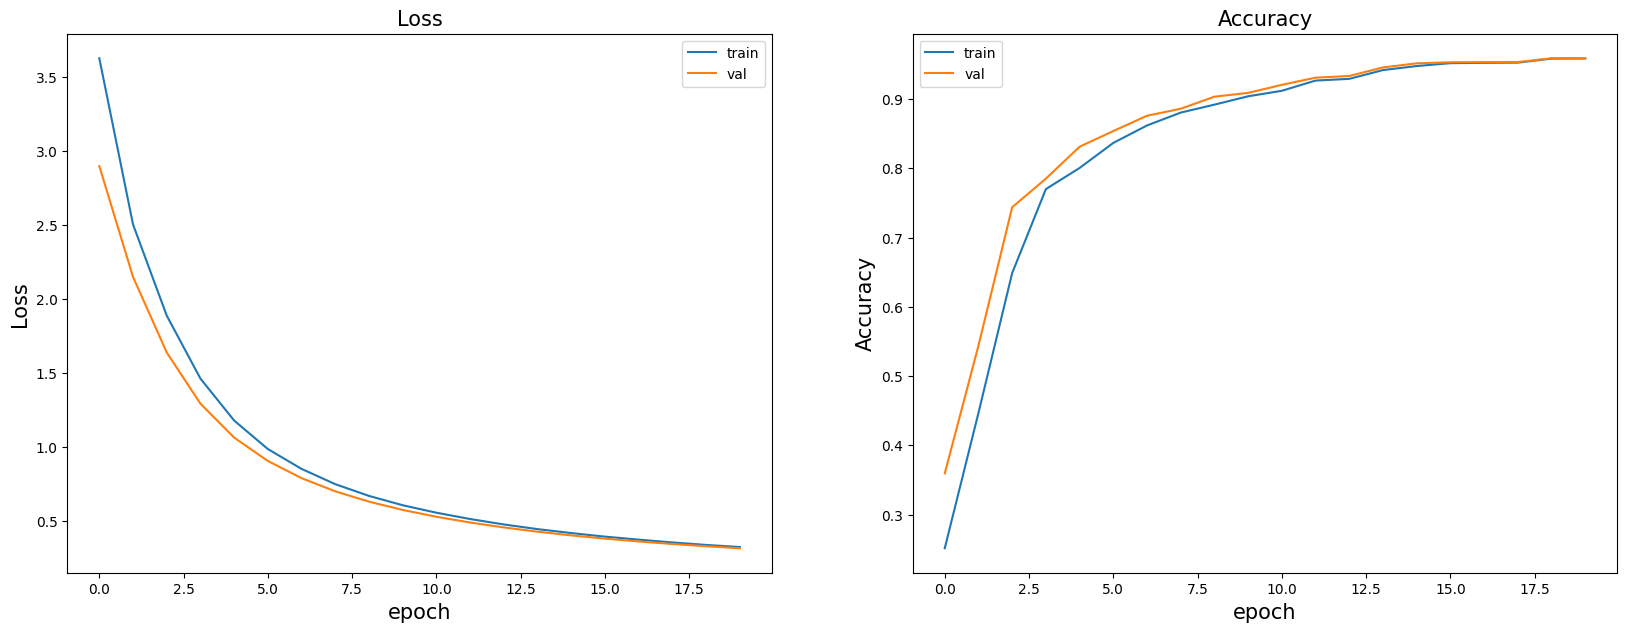

In [33]:
plot_learning_curves(dict_proverbs)

## 4.9 Validate model using a test phrase

### 4.9.1 Choose test phrase that is not present among our proverbs list, encrypt it using the same algorithm as used in our RNN model

__We'll make sure our test phrase only contains characters present in our extended vocabulary.__

In [34]:
test_phrase = ("Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска" 
" информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.")
# test_phrase = """Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска
#  информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно."""
print("Test phrase has length", len(test_phrase))
# test_phrase = test_phrase[:95]
print("Test phrase is:\n", test_phrase)
test_phrase_encr = caesar(test_phrase, vocab,2)
print("Encrypted test phrase is:\n", test_phrase_encr)

Test phrase has length 190
Test phrase is:
 Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.
Encrypted test phrase is:
 Стжиёж щжо йвёвфю дрстру, срстргхлфж пвлфк рфджф д кпфжтпжфж. Пвдэм уворуфрбфжнюпрер сркумв кпцртовшкк — рёкп кй двипжлъкч. Мвиёэл ствмфкмхаыкл усжшквнкуф нагрер хтрдпб ёжнвжф яфр жижёпждпр.


### 4.9.2 Encode test phrase and its encrypted version

In [35]:
# print([vocab_plus.get(tok, -1) for tok in test_phrase_encr])
# test_phrase_encr_encoded = torch.as_tensor([vocab_plus.get(tok, -1) for tok in test_phrase_encr])
test_phrase_encr_encoded = torch.as_tensor([vocab_plus[tok] for tok in test_phrase_encr])
# print(test_phrase_encr_encoded)

In [36]:
# test_phrase_encoded = torch.as_tensor([vocab_plus.get(tok, -1) for tok in test_phrase])
test_phrase_encoded = torch.as_tensor([vocab_plus[tok] for tok in test_phrase])
# print(test_phrase_encoded)

### 4.9.3 Wrap test phrase and its encrypted version in a batch

In [38]:
test_batch = [(test_phrase_encr_encoded,test_phrase_encoded)]
# print(test_batch)

### 4.9.4 Run encrypted test phrase through our model

In [45]:
# simple_rnn.to('cpu')
with torch.no_grad():
# simple_rnn.eval()
    res = simple_rnn(pad_and_pack_collate(test_batch)[0].to(device))

In [46]:
print(res.shape)

torch.Size([190, 81])


In [47]:
res = res.argmax(dim=1)

### 4.9.5 Re-code predicted (=decrypted) phrase as string of characters

In [48]:
anti_vocab_plus = {v:k for k,v in vocab_plus.items()}

In [49]:
pred_phrase = "".join([anti_vocab_plus[i.item()] for i in res])
print(pred_phrase)

урежде чем задать вопрос, попробуйте найти ответ в интернете.  авык самостоятельного поиска ин ормайии — один из важнейших.  аждый практикугмий спегиалист лгбого уровня делает ато ежедневно.


### 4.9.6 Calculate percentage of correctly decrypted characters (accuracy)

In [53]:
sum([test_phrase[i] == pred_phrase[i] for i in range(len(test_phrase))])/len(test_phrase)

0.9473684210526315

# 5. Make a dataset using randomly generated pieces of text

__Let's now build a dataset of randomly generated phrases using our extended vocabulary and see if training our RNN model will perform differently with this dataset.__

## 5.1 Create a list of artificial pieces of text

__We'll generate a list of the same length as our proverbs list, with the same maximum and minimum phrase length. Length distribution and positional distribution of characters will of course be different.__

In [54]:
strings = []
for i in range(length):
#     strings.append(''.join(random.choices(string.ascii_uppercase, k=10)))
    strings.append(''.join(random.choices(azb + azb_extra, k=random.randint(min_len,max_len+1))))

In [55]:
print(strings[:10])

['лМо)мХРЖЧ»?х.Кч!', 'ётВЕм;;ФпШ!ВзъГмЧяуЛ\'Щ,)Ь"-сгНуДЙГВвЬЪшыЮбНЦпюФг оШОйИЛБявьНл', 'ЭыА,ОЛС ЮХрФцФИЗёцяЪПШЭЙвЩажзап,вЧЧадйШтпжэ)ЖАР-ъф Н\'к»КСн\'ХСЕХцршсБ–ЯыЕУЭьЖ–)-о«ЙШЮЕНМын?вояФЩ";"Я?Х', 'МТЮч-оС;УУЯв,мИЗЧнхБн,пл«ЪЛуи)ГЖАКЩ«З"ЙЛПТ', 'ГмЩруичд»и;ЛЕМЗЩНз\'!ЪМа)фОЛэЗъЕ»Э"ьЖПъёдпэлМо;ЬЛьГпЖКМ УЗЪжПВыя:хуоБ(ьъг?У-—Еч', 'гЦ" Ч елЩВеЖКгъ:шОэнибя?ЧэЦ', 'ЫЫяВа—р—рПФж;ЦТишу.СЬВ(.флйГ-ХЙг', 'Уи–-\'!квИлеВЪ?жхКзсы,Иая?ИЧР»«щ»Г«ЖИИТ;ЯБЕЙЭщШюПмфПвЫм)"ц', 'эЮжзИмх(ЙИец—юЪЭ', 'оЮ..!ПюОё""Д-!вкщН.спВ((ЦО«ц:']


In [56]:
print(caesar(strings[:10],vocab))

['мНп)нЦСЗШ»?ц.Лш!', 'жуГЖн;;ХрЩ!ГиыДнШафМ\'Ъ,)Э"-тдОфЕКДГгЭЫщьЯвОЧряХд пЩПкЙМВагэОм', 'ЮьБ,ПМТ ЯЦсХчХЙИжчаЫРЩЮКгЪбзибр,гШШбекЩурзю)ЗБС-ых О\'л»ЛТо\'ЦТЖЦчсщтВ–АьЖФЮэЗ–)-п«КЩЯЖОНьо?гпаХЪ";"А?Ц', 'НУЯш-пТ;ФФАг,нЙИШоцВо,рм«ЫМфй)ДЗБЛЪ«И"КМРУ', 'ДнЪсфйше»й;МЖНИЪОи\'!ЫНб)хПМюИыЖ»Ю"эЗРыжерюмНп;ЭМэДрЗЛН ФИЫзРГьа:цфпВ(эыд?Ф-—Жш', 'дЧ" Ш ёмЪГёЗЛды:щПюойва?ШюЧ', 'ЬЬаГб—с—сРХз;ЧУйщф.ТЭГ(.хмкД-ЦКд', 'Фй–-\'!лгЙмёГЫ?зцЛить,Йба?ЙШС»«ъ»Д«ЗЙЙУ;АВЖКЮъЩяРнхРгЬн)"ч', 'юЯзиЙнц(КЙёч—яЫЮ', 'пЯ..!РяПж""Е-!глъО.трГ((ЧП«ч:']


## 5.2 Make a new dataset

In [57]:
ds_strings = CaesarDataset(strings, vocab_plus, caesar, vocab, 2)

In [58]:
print(len(ds_strings),len(ds_strings)-int((len(ds_strings)*0.3)))

3659 2562


## 5.3 Redefine train and test subsets, and data loaders

In [59]:
train_data, test_data = torch.utils.data.random_split(ds_strings, ( int((length*0.3)), length-int((length*0.3)) ) )

In [60]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_and_pack_collate)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_and_pack_collate)

# 6. Train model using a randomly generated dataset

## 6.1 Train model with new data loaders

In [63]:
simple_rnn.apply(weight_reset)
history = defaultdict(lambda: defaultdict(list))
for ep in range(20):
    start = time.time()
    train_loss, test_loss, train_acc, test_acc = 0.,0.,0.,0.
    iter_passed = 0
    
#     for inputs, targets in tqdm(data_loader, desc=desc, leave=False):
    simple_rnn.train()
    for inputs, targets in train_loader:
        inputs  =  inputs.to(device)

        optimizer.zero_grad()
        answers = simple_rnn(inputs)
        answers = answers.view(-1, len(vocab_plus)) # NOT NECESSARY SINCE BATCHES ARE CONCATENATED IN AFTER_RNN LAYER
        
#         targets = targets.flatten().to(device) # WON'T WORK SINCE TARGETS IS A LIST
#         targets = targets.view(1, -1).squeeze() # WON'T WORK SINCE TARGETS IS A LIST
        targets = torch.as_tensor([target for batch in targets for target in batch]).to(device)
        loss = criterion(answers, targets)
        train_loss += loss.item()
        
        train_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]

        loss.backward()
        optimizer.step()
        iter_passed += 1
        
        torch.cuda.empty_cache()
        gc.collect()
    
    train_acc /= iter_passed
    train_loss /= iter_passed
    history['loss']['train'].append(train_loss)
    history['acc']['train'].append(train_acc)
    iter_passed = 0
        
    simple_rnn.eval()
    for inputs, targets in test_loader:
        inputs  =  inputs.to(device)

        optimizer.zero_grad()
        answers = simple_rnn(inputs)
        answers = answers.view(-1, len(vocab_plus))
        
#         targets = targets.flatten().to(device) # WON'T WORK SINCE TARGETS IS A LIST
#         targets = targets.view(1, -1).squeeze() # WON'T WORK SINCE TARGETS IS A LIST
        targets = torch.as_tensor([target for batch in targets for target in batch]).to(device)
        loss = criterion(answers, targets)
        test_loss += loss.item()
        
        test_acc += (answers.argmax(dim=1) == targets).sum().item()/answers.shape[0]

        iter_passed += 1
        
        torch.cuda.empty_cache()
        gc.collect()
    
    test_acc /= iter_passed
    test_loss /= iter_passed
    history['loss']['val'].append(test_loss)
    history['acc']['val'].append(test_acc)

    print("Epoch {}. Time: {:.3f}, train loss: {:.3f}, train accuracy: {:.3f}, "
          "test loss: {:.3f}, test accuracy: {:.3f},".format(ep+1, time.time() - start, 
                                                               train_loss, train_acc, test_loss, test_acc))
dict_strings  = {'dict': history, 'tag': 'with random strings dataset'}

Epoch 1. Time: 38.245, train loss: 4.301, train accuracy: 0.064, test loss: 4.124, test accuracy: 0.104,
Epoch 2. Time: 37.938, train loss: 3.962, train accuracy: 0.166, test loss: 3.798, test accuracy: 0.245,
Epoch 3. Time: 37.939, train loss: 3.638, train accuracy: 0.316, test loss: 3.476, test accuracy: 0.395,
Epoch 4. Time: 37.944, train loss: 3.317, train accuracy: 0.458, test loss: 3.157, test accuracy: 0.521,
Epoch 5. Time: 37.816, train loss: 3.003, train accuracy: 0.592, test loss: 2.850, test accuracy: 0.664,
Epoch 6. Time: 37.814, train loss: 2.706, train accuracy: 0.727, test loss: 2.563, test accuracy: 0.783,
Epoch 7. Time: 37.871, train loss: 2.430, train accuracy: 0.828, test loss: 2.299, test accuracy: 0.868,
Epoch 8. Time: 37.848, train loss: 2.178, train accuracy: 0.899, test loss: 2.061, test accuracy: 0.917,
Epoch 9. Time: 38.384, train loss: 1.953, train accuracy: 0.930, test loss: 1.849, test accuracy: 0.943,
Epoch 10. Time: 38.401, train loss: 1.752, train accura

## 6.2 Plot loss and accuracy vs epoch

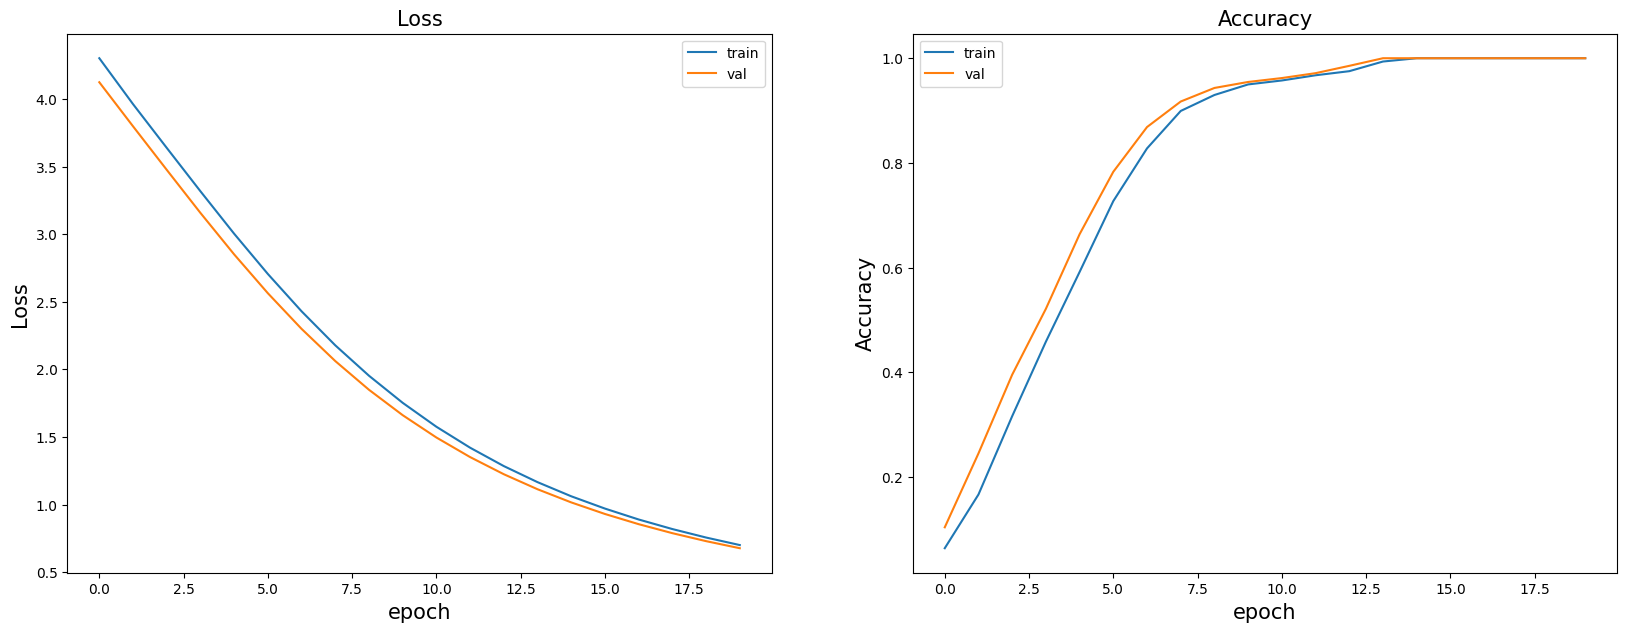

In [64]:
# plot_learning_curves(dict_strings['dict'])
plot_learning_curves(dict_strings)

## 6.3 Validate model using the test phrase, defined previously

In [65]:
with torch.no_grad():
# simple_rnn.eval()
    res = simple_rnn(pad_and_pack_collate(test_batch)[0].to(device))
    res = res.argmax(dim=1).cpu()

In [66]:
pred_phrase = "".join([anti_vocab_plus[i.item()] for i in res])
print(pred_phrase)

Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.


In [67]:
pred_phrase == test_phrase

True

# 7. Compare model performance when trained on real-language vs artificial datasets

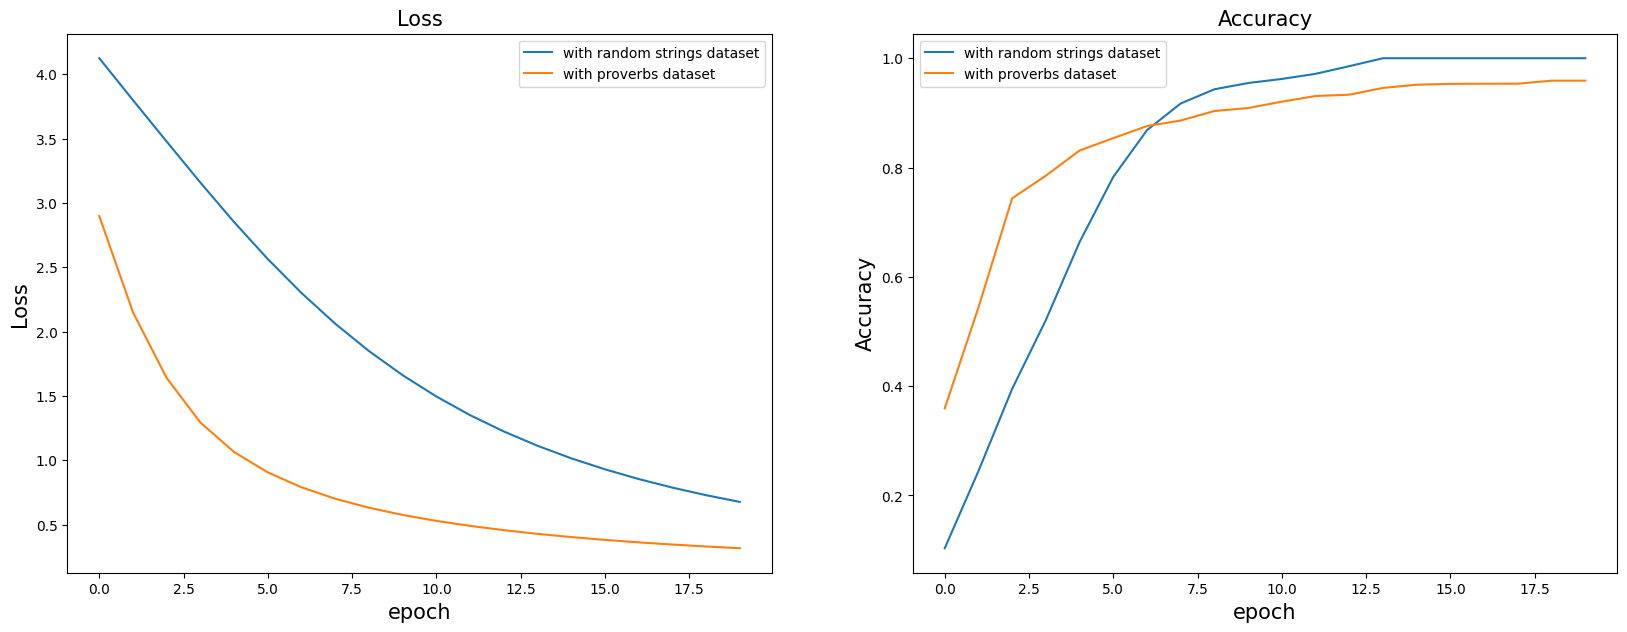

In [68]:
plot_learning_curves(dict_strings,dict_proverbs)

__Training on randomly generated strings, albeit a little slower, leads to better (maximum possible) accuracy. Training on real-language phrases leads to errors in decrypting capital letters, since there are a lot fewer of them in real language texts.__